In [7]:
# !pip3 install kafka-python==1.4.7 streamz==0.5.2 --user

In [2]:
import os
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import waterhealer as wh
import json
import logging

logging.basicConfig(level=logging.INFO)
wh.__version__

'0.1.6'

In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [5]:
brokers = 'localhost:29092'

In [6]:
source = wh.from_kafka_batched_scatter(
    ['testing'],
    {
        'bootstrap.servers': brokers,
        'group.id': 'group-test-5',
        'auto.offset.reset': 'latest',
    },
    dask = True
)

In [7]:
def json_loads(rows):
    results = []
    for row in rows:
        results.append((row[0], json.loads(row[1])))
    return results

def plus(rows, m = 30):
    results = []
    for row in rows:
        no = row[1]['no']
        if no > m:
            raise Exception(f'{row}, {no} is bigger than {m}')
        results.append((row[0], no + 1))
    return results

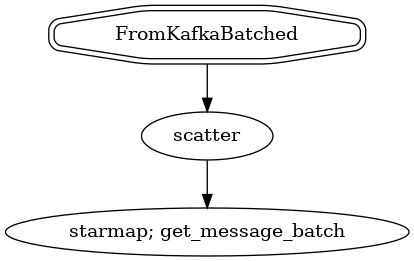

In [8]:
source.visualize()

In [9]:
outputs = []
h = source.map(json_loads).map(plus).buffer(5).gather().flatten().healing(interval = 5)
h.sink(outputs.append)

Output()

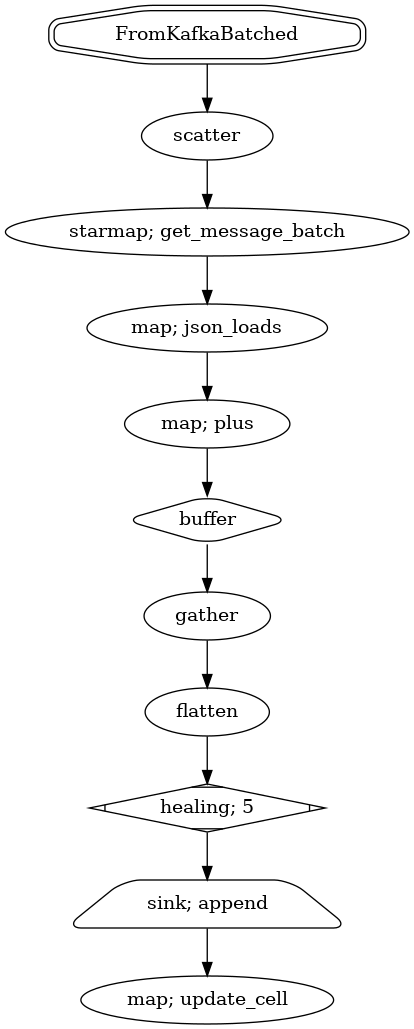

In [10]:
source.visualize()

In [11]:
source.start()

In [12]:
outputs

[]

In [13]:
from kafka import KafkaProducer
from kafka.partitioner import RoundRobinPartitioner

In [14]:
producer = KafkaProducer(
    bootstrap_servers = brokers.split(','),
    api_version = (0, 10),
    partitioner = RoundRobinPartitioner(),
)

INFO:kafka.conn:<BrokerConnection node_id=bootstrap-0 host=10.148.15.247:7095 <connecting> [IPv4 ('10.148.15.247', 7095)]>: connecting to 10.148.15.247:7095 [('10.148.15.247', 7095) IPv4]
INFO:kafka.conn:<BrokerConnection node_id=bootstrap-0 host=10.148.15.247:7095 <connecting> [IPv4 ('10.148.15.247', 7095)]>: Connection complete.


In [15]:
producer.bootstrap_connected()

True

In [16]:
from datetime import datetime
import json

def publish_message(producer_instance, topic_name, key, value):
    try:
        key_bytes = bytes(key, encoding = 'utf-8')
        value_bytes = bytes(value, encoding = 'utf-8')
        x = producer_instance.send(topic_name, value = value_bytes)
        return True
    except Exception as ex:
        print('Exception in publishing message')
        print(str(ex))
        return False

## purposely raise the error

Based on function `plus`, if input bigger than 30, it will throw error.

In [17]:
import time

for count in range(35):
    data = {'no': count, 'datetime': str(datetime.now())}
    print(data)
    publish_message(
        producer, 'testing', 'streaming', json.dumps(data)
    )
    time.sleep(0.1)

INFO:kafka.conn:<BrokerConnection node_id=1 host=10.148.15.247:7095 <connecting> [IPv4 ('10.148.15.247', 7095)]>: connecting to 10.148.15.247:7095 [('10.148.15.247', 7095) IPv4]
INFO:kafka.conn:<BrokerConnection node_id=1 host=10.148.15.247:7095 <connecting> [IPv4 ('10.148.15.247', 7095)]>: Connection complete.
INFO:kafka.conn:<BrokerConnection node_id=bootstrap-0 host=10.148.15.247:7095 <connected> [IPv4 ('10.148.15.247', 7095)]>: Closing connection. 
INFO:kafka.conn:<BrokerConnection node_id=0 host=10.148.15.246:7095 <connecting> [IPv4 ('10.148.15.246', 7095)]>: connecting to 10.148.15.246:7095 [('10.148.15.246', 7095) IPv4]
INFO:kafka.conn:<BrokerConnection node_id=0 host=10.148.15.246:7095 <connecting> [IPv4 ('10.148.15.246', 7095)]>: Connection complete.


{'no': 0, 'datetime': '2021-10-25 04:54:18.152948'}
{'no': 1, 'datetime': '2021-10-25 04:54:18.257834'}
{'no': 2, 'datetime': '2021-10-25 04:54:18.359633'}
{'no': 3, 'datetime': '2021-10-25 04:54:18.460277'}
{'no': 4, 'datetime': '2021-10-25 04:54:18.560787'}
{'no': 5, 'datetime': '2021-10-25 04:54:18.661400'}
{'no': 6, 'datetime': '2021-10-25 04:54:18.761971'}
{'no': 7, 'datetime': '2021-10-25 04:54:18.863486'}
{'no': 8, 'datetime': '2021-10-25 04:54:18.964518'}
{'no': 9, 'datetime': '2021-10-25 04:54:19.065569'}
{'no': 10, 'datetime': '2021-10-25 04:54:19.166216'}
{'no': 11, 'datetime': '2021-10-25 04:54:19.266799'}
{'no': 12, 'datetime': '2021-10-25 04:54:19.367429'}
{'no': 13, 'datetime': '2021-10-25 04:54:19.467997'}
{'no': 14, 'datetime': '2021-10-25 04:54:19.568595'}
{'no': 15, 'datetime': '2021-10-25 04:54:19.669318'}
{'no': 16, 'datetime': '2021-10-25 04:54:19.769922'}
{'no': 17, 'datetime': '2021-10-25 04:54:19.870526'}
{'no': 18, 'datetime': '2021-10-25 04:54:19.972548'}
{'n

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f837743d490>>, <Future finished exception=Exception("({'partition': 1, 'offset': 67, 'topic': 'testing'}, {'no': 31, 'datetime': '2021-10-25 04:54:21.284887'}), 31 is bigger than 30")>)
Traceback (most recent call last):
  File "/home/jovyan/.local/lib/python3.7/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home/jovyan/.local/lib/python3.7/site-packages/tornado/ioloop.py", line 765, in _discard_future_result
    future.result()
  File "/home/jovyan/.local/lib/python3.7/site-packages/tornado/gen.py", line 769, in run
    yielded = self.gen.throw(*exc_info)  # type: ignore
  File "/home/jovyan/water-healer/waterhealer/core.py", line 1227, in cb
    yield self._emit(x)
  File "/home/jovyan/.local/lib/python3.7/site-packages/tornado/gen.py", line 762, in run
    value = future.result()


In [19]:
from waterhealer.healing import get_memory

In [21]:
_, consumer, _ = get_memory(source)
consumer

In [23]:
offsets = consumer.committed(consumer.assignment())
lags = {}
for offset in offsets:
    _, high_offset = consumer.get_watermark_offsets(offset)
    lags[offset.partition] = high_offset - offset.offset
lags

{}